In [ ]:
!pip install pydicom
import numpy as np
import matplotlib.pyplot as plt
import pydicom
from skimage.segmentation import clear_border
from skimage.measure import label, regionprops
from scipy.ndimage import binary_fill_holes, binary_dilation, center_of_mass
import scipy.ndimage as ndi

# Load the DICOM file
filepath = r'/content/drive/MyDrive/SortedDataset1/Lung_Dx-G0044/09-25-2010-NA-PET03CBMWholebodyFirstHead Adult-08335/10.000000-Thorax  1.0  B70f-24757/1-108.dcm'
dicom_data = pydicom.dcmread(filepath)

# Extract the pixel array
img = dicom_data.pixel_array


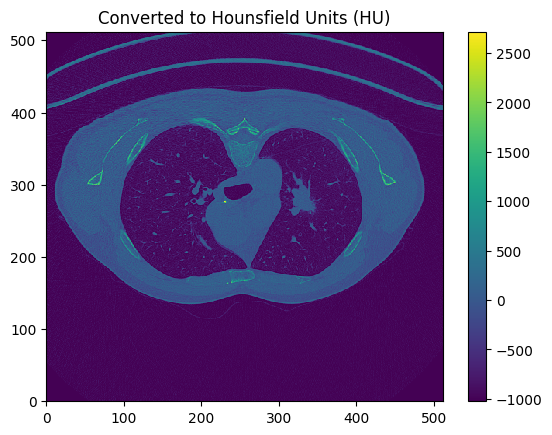

HU range: -1024.0 to 2716.0


In [ ]:
# Extract Rescale Slope and Intercept from DICOM metadata
rescale_slope = dicom_data.RescaleSlope
rescale_intercept = dicom_data.RescaleIntercept

# Convert pixel values to Hounsfield Units (HU)
hu_image = img * rescale_slope + rescale_intercept

# Display the converted HU image
plt.figure()
plt.pcolormesh(hu_image)
plt.colorbar()
plt.title("Converted to Hounsfield Units (HU)")
plt.show()

print(f"HU range: {hu_image.min()} to {hu_image.max()}")


In [ ]:
slice_2d = hu_image


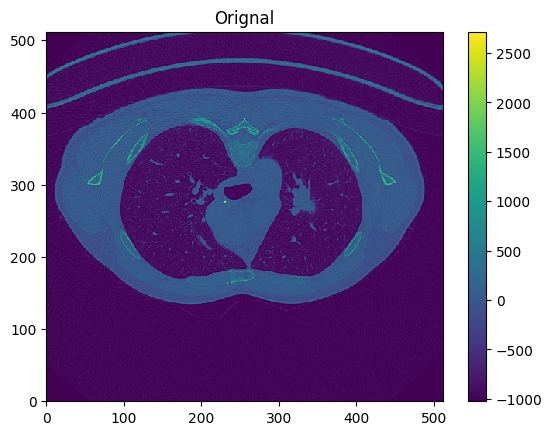

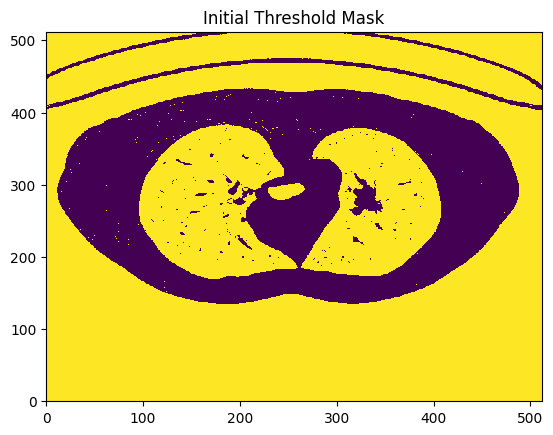

In [ ]:
plt.figure()
plt.pcolormesh(slice_2d)
plt.colorbar()
plt.title("Orignal")
plt.show()


# Step 1: Thresholding to create a binary mask
threshold = -320  # Adjust based on DICOM HU scaling if needed
mask_2d = slice_2d < threshold

# Plot the mask
plt.figure()
plt.pcolormesh(mask_2d)
plt.title("Initial Threshold Mask")
plt.show()



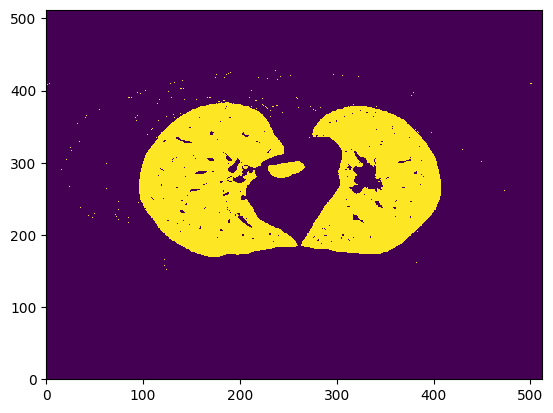

In [ ]:
mask_2d = np.vectorize(clear_border, signature='(n,m)->(n,m)')(mask_2d)
plt.pcolormesh(mask_2d)

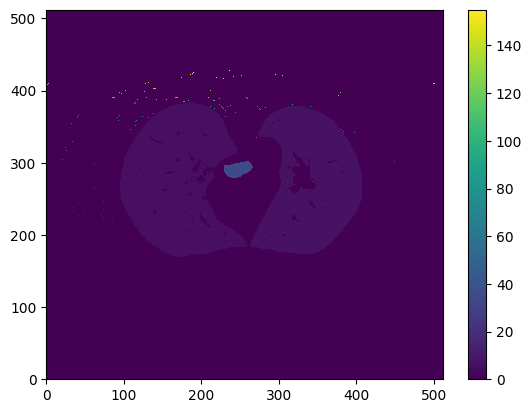

In [ ]:
mask_labeled = np.vectorize(label, signature='(n,m)->(n,m)')(mask_2d)
plt.pcolormesh(mask_labeled)
plt.colorbar()

In [ ]:
def keep_top_3(slc):
    new_slc = np.zeros_like(slc)
    rps = regionprops(slc)
    areas = [r.area for r in rps]
    idxs = np.argsort(areas)[::-1]
    for i in idxs[:3]:
        new_slc[tuple(rps[i].coords.T)] = i+1
    return new_slc

In [ ]:
mask_labeled = np.vectorize(keep_top_3, signature='(n,m)->(n,m)')(mask_labeled)

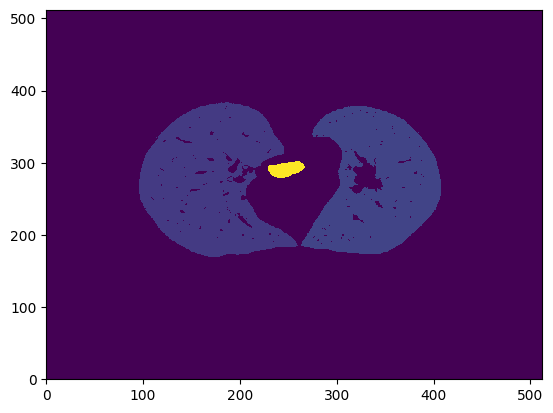

In [ ]:
plt.pcolormesh(mask_labeled)


In [ ]:
mask = mask_labeled > 0
mask = np.vectorize(ndi.binary_fill_holes, signature='(n,m)->(n,m)')(mask)

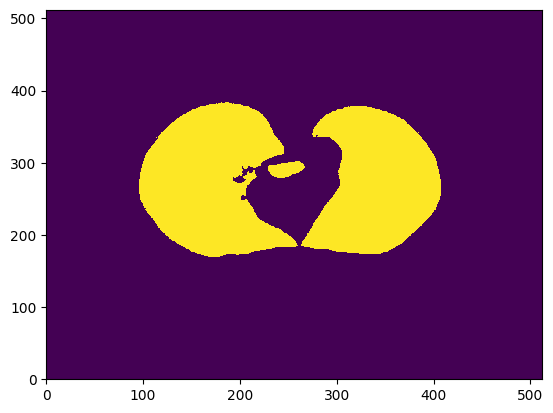

In [ ]:
plt.pcolormesh(mask)

In [ ]:
def remove_trachea(slc, c=0.0015):
    new_slc = slc.copy()
    labels = label(slc,connectivity=1,background=0)
    rps = regionprops(labels)
    areas = np.array([r.area for r in rps])
    idxs = np.where(areas/512**2 < c)[0]
    for i in idxs:
        new_slc[tuple(rps[i].coords.T)] = 0
    return new_slc

In [ ]:
mask = np.vectorize(remove_trachea, signature='(n,m)->(n,m)')(mask)


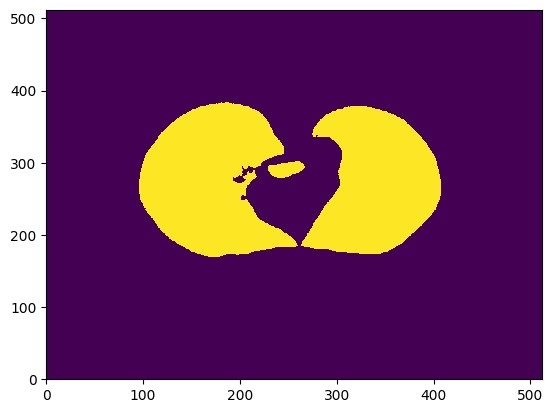

In [ ]:
plt.pcolormesh(mask)


In [ ]:
center_of_mass(mask_labeled==3)[0]

nan

In [ ]:
def delete_table(slc):
    new_slc = slc.copy()
    labels = label(slc, background=0)
    idxs = np.unique(labels)[1:]
    COM_ys = np.array([center_of_mass(labels==i)[0] for i in idxs])
    for idx, COM_y in zip(idxs, COM_ys):
        if (COM_y < 0.3*slc.shape[0]):
            new_slc[labels==idx] = 0
        elif (COM_y > 0.69*slc.shape[0]):
            new_slc[labels==idx] = 0
    return new_slc

In [ ]:
mask_new = np.vectorize(delete_table, signature='(n,m)->(n,m)')(mask)


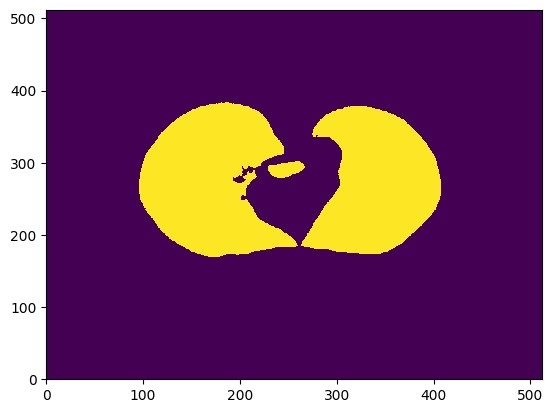

In [ ]:
plt.pcolormesh(mask_new)


In [ ]:
mask_new = binary_dilation(mask_new, iterations=1)

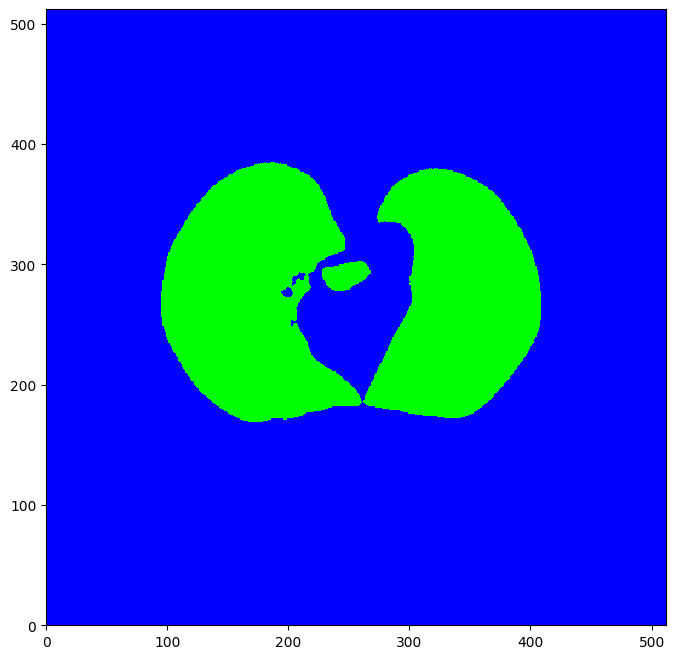

In [ ]:
plt.figure(figsize=(8,8))
plt.pcolormesh(mask_new, cmap='brg')

In [ ]:
img_new = mask_new * img

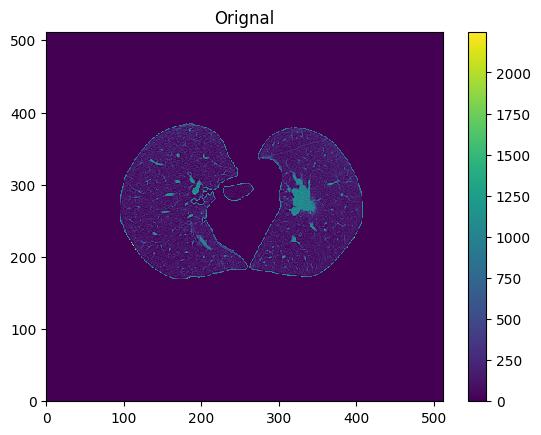

In [ ]:
plt.figure()
plt.pcolormesh(img_new)
plt.colorbar()
plt.title("Orignal")
plt.show()


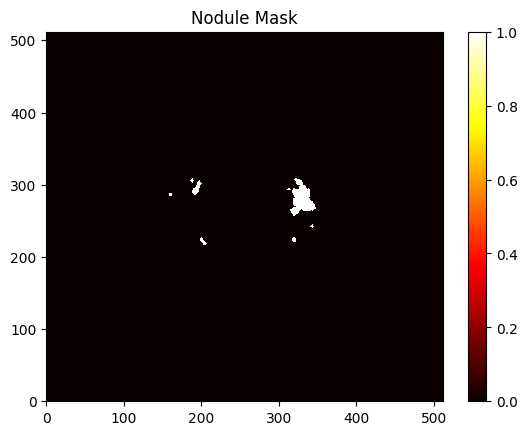

In [ ]:

# Define a threshold for potential nodules (e.g., dense regions in the lungs)
nodule_mask = (hu_image > -400) & mask_new  # HU > -400 and within lung mask

# Refine the nodule mask
from skimage.morphology import binary_opening, disk

nodule_mask = binary_opening(nodule_mask, disk(2))  # Remove small artifacts
nodule_mask = binary_fill_holes(nodule_mask)  # Fill holes within nodules

# Display the nodule mask
plt.pcolormesh(nodule_mask, cmap='hot')
plt.title("Nodule Mask")
plt.colorbar()
plt.show()
